# MLE/MAP estimation and gradient descent to determine the hidden state, $x$

Building on the ideas from the earlier notebooks, we now show the MLE/MAP estimation for the hidden state, $x$ and also estimating $x$ with gradient descent.

==========================================================================
* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* pyro-ppl==1.8.4
* pytorch==1.13.1

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch

from pyro.distributions import Normal

mpl.style.use("seaborn-deep")

To demonstrate MLE/MAP estimation, we will utilize the `pytorch` function for computing gradients. This is definitely overkill for our type of problem but will be useful to demonstrate gradient descent functionality. First, let's create our linear generating function. 

In [3]:
# Define the generating process
def G(x, beta_0, beta_1):
    y = beta_1 * x + beta_0
    return y

# Define the sampling process
def sample_gen_process(n, x_true):
    # torch.manual_seed(7867)
    y_i = Normal(loc=G(x_true, beta_0=3, beta_1=2), scale=0.5).sample([n])
    y_i = torch.reshape(y_i, (n, 1))
    return y_i

Next we need to generate data and create our negative log-likelihood (NLL) functions for the MLE and MAP estimates. For the MLE NLL all we need to do is take the negative of the log-likelihood over all samples. In the MAP case we do the same thing but also add the log-prior to it.

In [4]:
# Generate data
y_i = sample_gen_process(n=500, x_true=2.5)

def nll_mle(x):
    # Parameters
    likelihood_mean = G(x, beta_0=3, beta_1=2)
    likelihood_noise = 0.25
    
    # Model
    ll = Normal(loc=likelihood_mean, 
                scale=likelihood_noise).log_prob(y_i).sum(axis=0)
    nll = -ll
    return nll

def nll_map(x):
    # Parameters
    likelihood_mean = G(x, beta_0=3, beta_1=2)
    likelihood_noise = 0.25
    prior_mean = 2
    prior_noise = 0.25
    
    # Model
    ll = Normal(loc=likelihood_mean, 
                scale=likelihood_noise).log_prob(y_i).sum(axis=0)
    
    log_prior = Normal(loc=prior_mean,
                       scale=prior_noise).log_prob(x)
    
    nll = -(ll + log_prior)
    return nll

Now we perform gradient descent. All we are doing here repeatedly stepping down the function according to the gradient, updating $x$ until we hit the minima.

In [5]:
def gradient_descent(alpha, iterations, w, nll):
    print(f"Initializing at {w}.")
    
    w = torch.tensor(w, requires_grad=True)

    weights = [w.tolist()]
    costs = [nll(w).tolist()[0]]
    
    for i in range(iterations):
        nll_w = nll(w)
        nll_w.backward()

        with torch.no_grad():
            w -= (alpha * w.grad)
            w.grad.zero_()
        
        weights.append(w.tolist())
        costs.append(nll(w).tolist()[0])
        
    return weights, costs

In [6]:
weights_mle, costs_mle = gradient_descent(
    alpha = 0.000001, 
    iterations = 100, 
    w = 5., 
    nll = nll_mle)

Initializing at 5.0.


In [7]:
weights_map, costs_map = gradient_descent(
    alpha = 0.000001, 
    iterations = 100, 
    w = 4., 
    nll = nll_map)

Initializing at 4.0.


<Figure size 640x480 with 0 Axes>

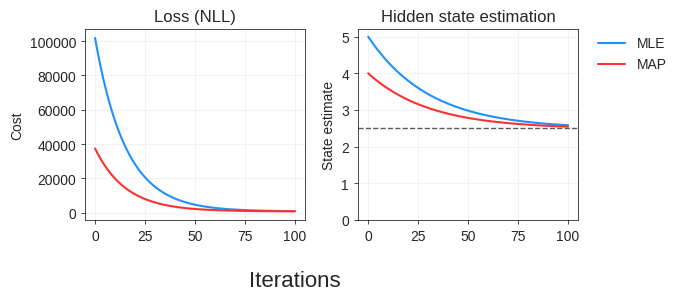

In [8]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,2, facecolor=(1,1,1), figsize=(6, 3))

# Main plot
axes[0].plot(list(range(0, len(costs_mle))), costs_mle, c="#1e90ff")
axes[0].plot(list(range(0, len(costs_map))), costs_map, c="#ff3030")
axes[1].plot(list(range(0, len(weights_mle))), weights_mle, c="#1e90ff", label="MLE")
axes[1].plot(list(range(0, len(weights_map))), weights_map, c="#ff3030", label="MAP")

# Titles
axes[0].set_title("Loss (NLL)")
axes[1].set_title("Hidden state estimation")

# Axis labels
axes[0].set_ylabel("Cost")
axes[1].set_ylabel("State estimate")

# Hidden state estimate plot customization
axes[1].set_ylim([0, 5.2])
axes[1].axhline(y=2.5, linestyle="dashed", linewidth=1, c="#595959")

# Axis global labels
fig.supxlabel("Iterations", fontsize=16)

# Cosmetic changes 
for ax in axes:
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

fig.legend(bbox_to_anchor=(1.14,0.9), loc='upper right', ncol=1)
fig.tight_layout()

Finally, we visualize the log-likelihood function (for MLE) and observe how gradient descent progressed down this function at each iteration. To obtain the NLL curve, we simply have to vary $x$ over the negative-log-likelihood as shown below. The weights ($x$) and costs ($y$) obtained above for each iteration of gradient descent can then be plotted onto the curve.

In [9]:
# Grid ranges (the range of values x can take)
x_min = 0.01
x_max = 5
x_points = 500

x_range = torch.linspace(start=x_min, end=x_max, steps=x_points).numpy()
y = [nll_mle(n).tolist()[0] for n in x_range]

<Figure size 640x480 with 0 Axes>

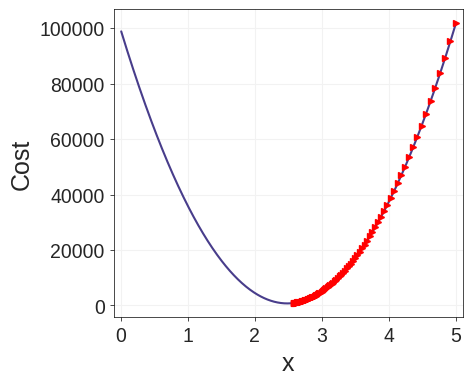

In [10]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1), figsize=(4.5,4))

# Plot NLL function
ax.plot(x_range, y, c="#483D8B")
ax.plot(weights_mle, costs_mle, "r>", ms=4.5)

# Set axes labels
ax.set_xlabel("x", fontsize=18)
ax.set_ylabel("Cost", fontsize=18)

ax.set_xlim([-0.1,5.1])
ax.set_xticks(range(0,6, 1))

# Axis labels and styling
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)